In [2]:
import pandas as pd

# Load data
training_features = pd.read_csv("C:\\Users\\deepi\\OneDrive\\Desktop\\Summer_Anlytics\\Hackathon_Summer analytics\\training_set_features.csv")
training_labels = pd.read_csv("C:\\Users\\deepi\\OneDrive\\Desktop\\Summer_Anlytics\\Hackathon_Summer analytics\\training_set_labels.csv")
test_features = pd.read_csv("C:\\Users\\deepi\\OneDrive\\Desktop\\Summer_Anlytics\\Hackathon_Summer analytics\\test_set_features.csv")

# Inspect data
print("Training Features Shape:", training_features.shape)
print("Training Labels Shape:", training_labels.shape)
print("Test Features Shape:", test_features.shape)

print("\nTraining Features Info:")
print(training_features.info())

print("\nTraining Labels Info:")
print(training_labels.info())

print("\nTest Features Info:")
print(test_features.info())

# Check for missing values
print("\nMissing Values in Training Features:")
print(training_features.isnull().sum())

print("\nMissing Values in Training Labels:")
print(training_labels.isnull().sum())

print("\nMissing Values in Test Features:")
print(test_features.isnull().sum())

# Get basic statistics for each feature
print("\nTraining Features Description:")
print(training_features.describe())

print("\nTraining Labels Description:")
print(training_labels.describe())

print("\nTest Features Description:")
print(test_features.describe())


Training Features Shape: (26707, 36)
Training Labels Shape: (26707, 3)
Test Features Shape: (26708, 36)

Training Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   xyz_concern                  26615 non-null  float64
 2   xyz_knowledge                26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_xyz              24547 non-null  float64
 11  doc

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numeric features
categorical_features = training_features.select_dtypes(include=['object']).columns.tolist()
numeric_features = training_features.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features.remove('respondent_id')

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(training_features)
X_test_preprocessed = preprocessor.transform(test_features)

# Convert preprocessed data back to DataFrame for easy inspection
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed)

print("Preprocessed Training Features Shape:", X_train_preprocessed_df.shape)
print("Preprocessed Test Features Shape:", X_test_preprocessed_df.shape)


Preprocessed Training Features Shape: (26707, 105)
Preprocessed Test Features Shape: (26708, 105)


In [4]:
from sklearn.model_selection import train_test_split

# Define target variables
y = training_labels[['xyz_vaccine', 'seasonal_vaccine']]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_preprocessed_df, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)


Training Set Shape: (21365, 105) (21365, 2)
Validation Set Shape: (5342, 105) (5342, 2)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Define the model
model = MultiOutputClassifier(LogisticRegression())

# Train the model
model.fit(X_train, y_train)


C:\Users\deepi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\deepi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

MultiOutputClassifier(estimator=LogisticRegression())

In [6]:
from sklearn.metrics import roc_auc_score

# Predict probabilities on the validation set
y_val_pred = model.predict_proba(X_val)

# Extract the predicted probabilities for each label
y_val_pred_xyz = y_val_pred[0][:, 1]
y_val_pred_seasonal = y_val_pred[1][:, 1]

# Calculate ROC AUC scores
roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("Mean ROC AUC Score:", mean_roc_auc)


ROC AUC Score for XYZ Vaccine: 0.834349183537974
ROC AUC Score for Seasonal Vaccine: 0.8564368012209136
Mean ROC AUC Score: 0.8453929923794439


In [7]:
# Predict probabilities on the test set
y_test_pred = model.predict_proba(X_test_preprocessed_df)

# Extract the predicted probabilities for each label
y_test_pred_xyz = y_test_pred[0][:, 1]
y_test_pred_seasonal = y_test_pred[1][:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_test_pred_xyz,
    'seasonal_vaccine': y_test_pred_seasonal
})

# Save to CSV
submission.to_csv('submission.csv', index=False)


In [8]:
# Define the path to save the file
output_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv"

# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_test_pred_xyz,
    'seasonal_vaccine': y_test_pred_seasonal
})

# Save to CSV
submission.to_csv(output_path, index=False)

print(f"Submission file saved to: {output_path}")


Submission file saved to: C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv


ROC AUC Score for XYZ Vaccine: 0.834349183537974
ROC AUC Score for Seasonal Vaccine: 0.8564368012209136
Mean ROC AUC Score: 0.8453929923794439


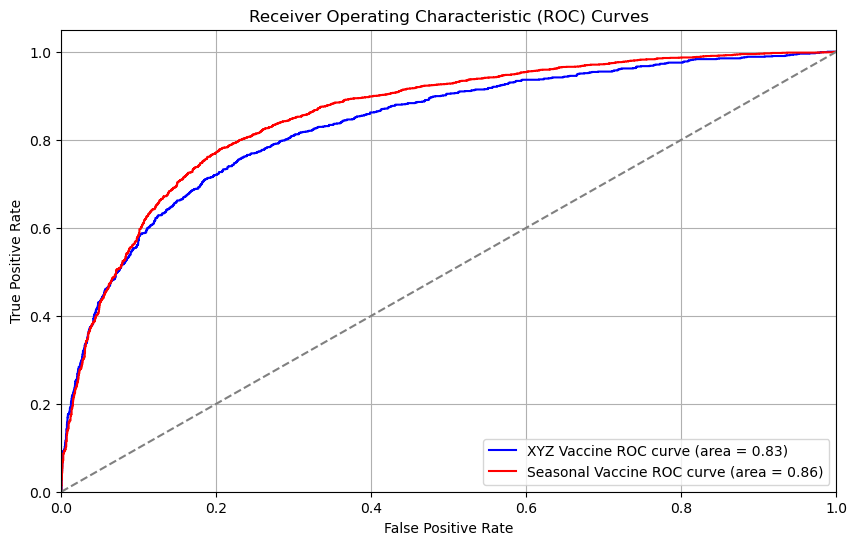

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities on the validation set
y_val_pred = model.predict_proba(X_val)

# Extract the predicted probabilities for each label
y_val_pred_xyz = y_val_pred[0][:, 1]
y_val_pred_seasonal = y_val_pred[1][:, 1]

# Calculate ROC AUC scores
roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("Mean ROC AUC Score:", mean_roc_auc)

# Get ROC curve data points
fpr_xyz, tpr_xyz, _ = roc_curve(y_val['xyz_vaccine'], y_val_pred_xyz)
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val['seasonal_vaccine'], y_val_pred_seasonal)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xyz, tpr_xyz, color='blue', label=f'XYZ Vaccine ROC curve (area = {roc_auc_xyz:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal Vaccine ROC curve (area = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


ROC plot saved to: C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\ROC.png


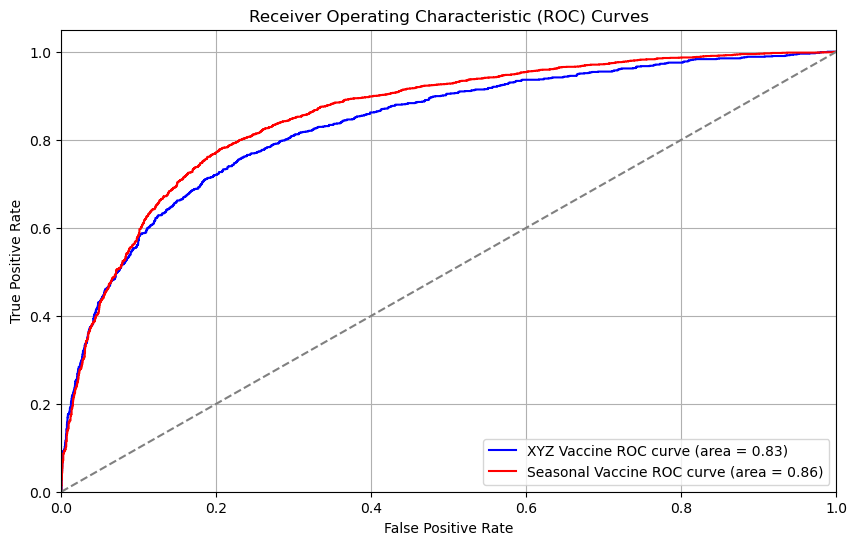

In [10]:
# Save the ROC plot
roc_plot_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\ROC.png"
plt.figure(figsize=(10, 6))
plt.plot(fpr_xyz, tpr_xyz, color='blue', label=f'XYZ Vaccine ROC curve (area = {roc_auc_xyz:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal Vaccine ROC curve (area = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(roc_plot_path)
print(f"ROC plot saved to: {roc_plot_path}")


In [11]:
# Predict probabilities on the test set
y_test_pred = model.predict_proba(X_test_preprocessed_df)

# Extract the predicted probabilities for each label
y_test_pred_xyz = y_test_pred[0][:, 1]
y_test_pred_seasonal = y_test_pred[1][:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_test_pred_xyz,
    'seasonal_vaccine': y_test_pred_seasonal
})

# Define the path to save the submission file
submission_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv"

# Save to CSV
submission.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")


Submission file saved to: C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Define the model
logistic_model = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Train the model
logistic_model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = logistic_model.predict_proba(X_val)
y_val_pred_xyz = y_val_pred[0][:, 1]
y_val_pred_seasonal = y_val_pred[1][:, 1]

roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("Logistic Regression ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("Logistic Regression ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("Logistic Regression Mean ROC AUC Score:", mean_roc_auc)


Logistic Regression ROC AUC Score for XYZ Vaccine: 0.8343508643656136
Logistic Regression ROC AUC Score for Seasonal Vaccine: 0.856433978690744
Logistic Regression Mean ROC AUC Score: 0.8453924215281787


In [13]:
from sklearn.svm import SVC

# Define the model
svm_model = MultiOutputClassifier(SVC(probability=True))

# Train the model
svm_model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = svm_model.predict_proba(X_val)
y_val_pred_xyz = y_val_pred[0][:, 1]
y_val_pred_seasonal = y_val_pred[1][:, 1]

roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("SVM ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("SVM ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("SVM Mean ROC AUC Score:", mean_roc_auc)


SVM ROC AUC Score for XYZ Vaccine: 0.8435433107262016
SVM ROC AUC Score for Seasonal Vaccine: 0.8581488774585825
SVM Mean ROC AUC Score: 0.8508460940923921


In [14]:
from sklearn.naive_bayes import GaussianNB

# Define the model
nb_model = MultiOutputClassifier(GaussianNB())

# Train the model
nb_model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = nb_model.predict_proba(X_val)
y_val_pred_xyz = y_val_pred[0][:, 1]
y_val_pred_seasonal = y_val_pred[1][:, 1]

roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("Naive Bayes ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("Naive Bayes ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("Naive Bayes Mean ROC AUC Score:", mean_roc_auc)


Naive Bayes ROC AUC Score for XYZ Vaccine: 0.7090353940280194
Naive Bayes ROC AUC Score for Seasonal Vaccine: 0.7410059017694584
Naive Bayes Mean ROC AUC Score: 0.7250206478987389


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
logistic = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Separate the target variables
y_train_xyz = y_train['xyz_vaccine']
y_train_seasonal = y_train['seasonal_vaccine']

# Define the grid search for xyz_vaccine
grid_search_xyz = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Train the grid search model for xyz_vaccine
grid_search_xyz.fit(X_train, y_train_xyz)

# Get the best estimator for xyz_vaccine
best_logistic_xyz = grid_search_xyz.best_estimator_

# Define the grid search for seasonal_vaccine
grid_search_seasonal = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Train the grid search model for seasonal_vaccine
grid_search_seasonal.fit(X_train, y_train_seasonal)

# Get the best estimator for seasonal_vaccine
best_logistic_seasonal = grid_search_seasonal.best_estimator_

print("Best hyperparameters for XYZ Vaccine:", grid_search_xyz.best_params_)
print("Best hyperparameters for Seasonal Vaccine:", grid_search_seasonal.best_params_)


Best hyperparameters for XYZ Vaccine: {'C': 0.1, 'solver': 'liblinear'}
Best hyperparameters for Seasonal Vaccine: {'C': 0.1, 'solver': 'liblinear'}


In [15]:
from sklearn.metrics import roc_auc_score

# Train the best models
best_logistic_xyz.fit(X_train, y_train_xyz)
best_logistic_seasonal.fit(X_train, y_train_seasonal)

# Predict probabilities on the validation set
y_val_pred_xyz = best_logistic_xyz.predict_proba(X_val)[:, 1]
y_val_pred_seasonal = best_logistic_seasonal.predict_proba(X_val)[:, 1]

# Calculate ROC AUC scores
roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("Best Logistic Regression ROC AUC Score for XYZ Vaccine:", roc_auc_xyz)
print("Best Logistic Regression ROC AUC Score for Seasonal Vaccine:", roc_auc_seasonal)
print("Best Logistic Regression Mean ROC AUC Score:", mean_roc_auc)


NameError: name 'best_logistic_xyz' is not defined

In [21]:
# Predict probabilities on the test set
y_test_pred_xyz = best_logistic_xyz.predict_proba(X_test_preprocessed_df)[:, 1]
y_test_pred_seasonal = best_logistic_seasonal.predict_proba(X_test_preprocessed_df)[:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_test_pred_xyz,
    'seasonal_vaccine': y_test_pred_seasonal
})

# Define the path to save the submission file
submission_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv"

# Save to CSV
submission.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")


Submission file saved to: C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv


In [ ]:
from sklearn.svm import SVC

# Define the model
svm_model = MultiOutputClassifier(SVC(probability=True))

# Train the model
svm_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_pred = svm_model.predict_proba(X_test_preprocessed_df)

# Extract the predicted probabilities for each label
y_test_pred_xyz = y_test_pred[0][:, 1]
y_test_pred_seasonal = y_test_pred[1][:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_test_pred_xyz,
    'seasonal_vaccine': y_test_pred_seasonal
})

# Define the path to save the submission file
submission_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\submission.csv"

# Save to CSV
submission.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

# Predict on the validation set
y_val_pred = svm_model.predict(X_val)

# Predict probabilities on the validation set for ROC AUC
y_val_pred_proba = svm_model.predict_proba(X_val)
y_val_pred_proba_xyz = y_val_pred_proba[0][:, 1]
y_val_pred_proba_seasonal = y_val_pred_proba[1][:, 1]

# Calculate accuracy, precision, recall for each target
accuracy_xyz = accuracy_score(y_val['xyz_vaccine'], y_val_pred[:, 0])
precision_xyz = precision_score(y_val['xyz_vaccine'], y_val_pred[:, 0])
recall_xyz = recall_score(y_val['xyz_vaccine'], y_val_pred[:, 0])
roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_proba_xyz)

accuracy_seasonal = accuracy_score(y_val['seasonal_vaccine'], y_val_pred[:, 1])
precision_seasonal = precision_score(y_val['seasonal_vaccine'], y_val_pred[:, 1])
recall_seasonal = recall_score(y_val['seasonal_vaccine'], y_val_pred[:, 1])
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_proba_seasonal)

# Mean scores
mean_accuracy = (accuracy_xyz + accuracy_seasonal) / 2
mean_precision = (precision_xyz + precision_seasonal) / 2
mean_recall = (recall_xyz + recall_seasonal) / 2
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print(f"Accuracy for XYZ Vaccine: {accuracy_xyz}")
print(f"Precision for XYZ Vaccine: {precision_xyz}")
print(f"Recall for XYZ Vaccine: {recall_xyz}")
print(f"ROC AUC for XYZ Vaccine: {roc_auc_xyz}")

print(f"Accuracy for Seasonal Vaccine: {accuracy_seasonal}")
print(f"Precision for Seasonal Vaccine: {precision_seasonal}")
print(f"Recall for Seasonal Vaccine: {recall_seasonal}")
print(f"ROC AUC for Seasonal Vaccine: {roc_auc_seasonal}")

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean ROC AUC: {mean_roc_auc}")


Accuracy for XYZ Vaccine: 0.8474354174466492
Precision for XYZ Vaccine: 0.7259684361549498
Recall for XYZ Vaccine: 0.44778761061946903
ROC AUC for XYZ Vaccine: 0.8435479330022104
Accuracy for Seasonal Vaccine: 0.7856608011980531
Precision for Seasonal Vaccine: 0.772765246449457
Recall for Seasonal Vaccine: 0.7547939616483068
ROC AUC for Seasonal Vaccine: 0.8581401981783108
Mean Accuracy: 0.8165481093223512
Mean Precision: 0.7493668413022034
Mean Recall: 0.6012907861338879
Mean ROC AUC: 0.8508440655902606


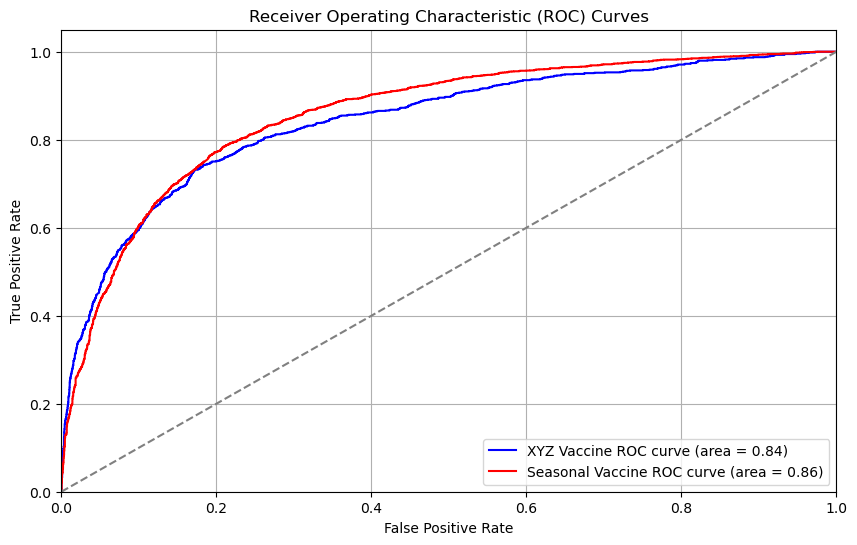

In [24]:
# Get ROC curve data points
fpr_xyz, tpr_xyz, _ = roc_curve(y_val['xyz_vaccine'], y_val_pred_proba_xyz)
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val['seasonal_vaccine'], y_val_pred_proba_seasonal)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xyz, tpr_xyz, color='blue', label=f'XYZ Vaccine ROC curve (area = {roc_auc_xyz:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal Vaccine ROC curve (area = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


ROC plot saved to: C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\ROC.png


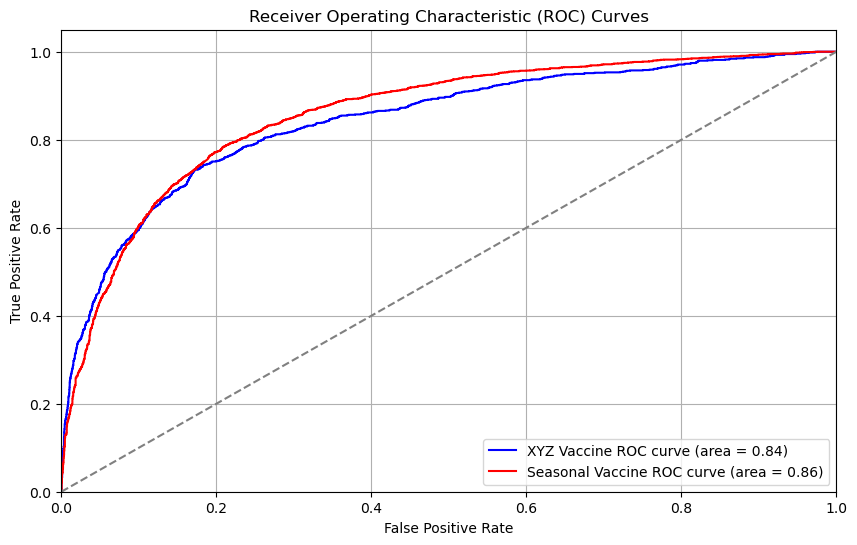

In [25]:
# Save the ROC plot
roc_plot_path = r"C:\Users\deepi\OneDrive\Desktop\Summer_Anlytics\Hackathon_Summer analytics\ROC.png"
plt.figure(figsize=(10, 6))
plt.plot(fpr_xyz, tpr_xyz, color='blue', label=f'XYZ Vaccine ROC curve (area = {roc_auc_xyz:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal Vaccine ROC curve (area = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(roc_plot_path)
print(f"ROC plot saved to: {roc_plot_path}")


In [26]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interactions = interaction.fit_transform(X_train)
X_val_interactions = interaction.transform(X_val)
X_test_interactions = interaction.transform(X_test_preprocessed_df)

# Convert back to DataFrame for inspection
X_train_interactions_df = pd.DataFrame(X_train_interactions)
X_val_interactions_df = pd.DataFrame(X_val_interactions)
X_test_interactions_df = pd.DataFrame(X_test_interactions)

print("Shape of training data with interaction features:", X_train_interactions_df.shape)


Shape of training data with interaction features: (21365, 5565)


In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define a simpler parameter grid for SVM
param_grid_svm = {
    'estimator__C': [0.1, 1],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__kernel': ['linear', 'rbf']
}

# Use a smaller subset of data for initial tuning
X_train_subset = X_train_interactions[:5000]
y_train_subset = y_train[:5000]

# Define the SVM model
svm = SVC(probability=True)

# Use MultiOutputClassifier to handle multi-label classification
multi_svm = MultiOutputClassifier(svm)

# Define the grid search
grid_search_svm = GridSearchCV(multi_svm, param_grid_svm, cv=3, scoring='roc_auc', n_jobs=-1)

# Train the grid search model on the subset
grid_search_svm.fit(X_train_subset, y_train_subset)

# Get the best estimator
best_svm = grid_search_svm.best_estimator_

print("Best hyperparameters for SVM:", grid_search_svm.best_params_)

# Now train the best SVM model on the full dataset
best_svm.fit(X_train_interactions, y_train)

# Evaluate the model
y_val_pred_proba = best_svm.predict_proba(X_val_interactions)
y_val_pred_proba_xyz = y_val_pred_proba[0][:, 1]
y_val_pred_proba_seasonal = y_val_pred_proba[1][:, 1]

roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_val_pred_proba_xyz)
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred_proba_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print("ROC AUC Score for XYZ Vaccine with class weights:", roc_auc_xyz)
print("ROC AUC Score for Seasonal Vaccine with class weights:", roc_auc_seasonal)
print("Mean ROC AUC Score with class weights:", mean_roc_auc)


NameError: name 'X_train_interactions' is not defined